# **CS 5361/6361 Machine Learning - PCA Exercise**

**Author:** Ruben Martinez<br>
Computer Science Department<br>
University of Texas at El Paso<br>
**Last modified:** 11/1/2024<br>

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt


def one_hot(y):
  oh = np.zeros((y.shape[0],np.amax(y)+1))
  oh[np.arange(y.shape[0]),y]=1
  return oh

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = np.float32(X_train.reshape(X_train.shape[0],-1)/255)
X_test = np.float32(X_test.reshape(X_test.shape[0],-1)/255)
y_train_oh = one_hot(y_train)
y_test_oh = one_hot(y_test)

print(X_train.shape)
print(X_test.shape)
print(y_train_oh.shape)
print(y_test_oh.shape)

(60000, 784)
(10000, 784)
(60000, 10)
(10000, 10)


### 1. Write a function that receives a trained pca model and a floating point number v, in the 0,1 range, and returns the number of principal components necessary to obtain the explained variance fraction v.

In [2]:
def num_principal_components(model, v):

    total_explained_variance = 0
    num_components = 0

    for explained_variance_ratio in model.explained_variance_ratio_:
        total_explained_variance += explained_variance_ratio # add the current decimal to the total
        num_components += 1 # increment the number of components

        if total_explained_variance >= v: # if the accumulated becomes equal to or exceeds v
            return num_components # return the number of components

    return num_components # we used all components


To reach 50.0% explained variance, number of components required: 11
To reach 75.0% explained variance, number of components required: 34
To reach 90.0% explained variance, number of components required: 87
To reach 95.0% explained variance, number of components required: 154
To reach 99.0% explained variance, number of components required: 331
To reach 100% explained variance, number of components required: 784


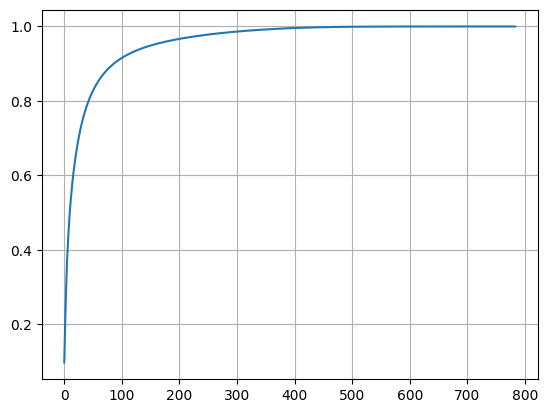

In [3]:
pca_model = PCA(n_components = X_train.shape[1])
pca_model.fit(X_train)

thresholds = [.5, .75, .9, .95, .99, 1] # choose some random thresholds

for threshold in thresholds:
    num_components = num_principal_components(pca_model, threshold) # obtain the number of principal components (eigenvectors) to reach the required threshold
    print(f"To reach {threshold * 100}% explained variance, number of components required: {num_components}")


ev = np.cumsum(pca_model.explained_variance_)
ev = ev/ev[-1]
plt.plot(ev)
plt.grid(True)

I created a function to determine the minimum number of principal components needed to capture a specified fraction of explained variance in the MNIST dataset. The function works by iterating through the `explained_variance_ratio_` values provided by the PCA model, which represent how much variance each component captures relative to the total. It accumulates these values until they reach the target variance fraction, counting the number of components as it goes. Through this function, I found that only 11 components captured 50% of the variance, 34 captured 75%, and 87 captured 90%. After that, the required number of components increased significantly, with 154 needed for 95% and 331 for 99%. The plot showed a steep initial rise, confirming that a small subset captures most of the data’s structure, while additional components contribute diminishing returns. Creating this function gave me a clearer understanding of how PCA leverages eigenvalues and eigenvectors to reduce dimensionality effectively.

### 2. Experiment with PCA preprocessing to determine the minimum number of principal components required to classify the MNIST dataset using the sklearn implementation of k-nearest neighbors with: <br> a. 90% accuracy <br> b. 95% accuracy <br> c. 97% accuracy <br>

In [4]:
accuracy_targets = {.9: None, .95: None, .97: None}

pca = PCA(n_components = X_train.shape[1])

pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

components_list = []
accuracy_list = []


for n in range(8, X_train.shape[1], 1):

    knn_model = KNeighborsClassifier()
    knn_model.fit(X_train_pca[:,:n], y_train_oh) # train with only first n features

    pred = knn_model.predict(X_test_pca[:,:n])
    accuracy = accuracy_score(y_test, np.argmax(pred, axis=1))

    components_list.append(n) # add to list for plotting
    accuracy_list.append(accuracy) # add accuracy to list for plotting

    print(f"Number of components: {n}, Accuracy: {accuracy}")

    for target in accuracy_targets:
        if accuracy >= target and accuracy_targets[target] == None:
            accuracy_targets[target] = n

    if all(accuracy_targets.values()):
        break

Number of components: 8, Accuracy: 0.8917
Number of components: 9, Accuracy: 0.9077
Number of components: 10, Accuracy: 0.9228
Number of components: 11, Accuracy: 0.931
Number of components: 12, Accuracy: 0.9398
Number of components: 13, Accuracy: 0.9482
Number of components: 14, Accuracy: 0.9521
Number of components: 15, Accuracy: 0.9549
Number of components: 16, Accuracy: 0.9596
Number of components: 17, Accuracy: 0.9611
Number of components: 18, Accuracy: 0.9632
Number of components: 19, Accuracy: 0.965
Number of components: 20, Accuracy: 0.9661
Number of components: 21, Accuracy: 0.9676
Number of components: 22, Accuracy: 0.968
Number of components: 23, Accuracy: 0.9691
Number of components: 24, Accuracy: 0.97


Results:
Minimum components for 90.0% accuracy: 9
Minimum components for 95.0% accuracy: 14
Minimum components for 97.0% accuracy: 24


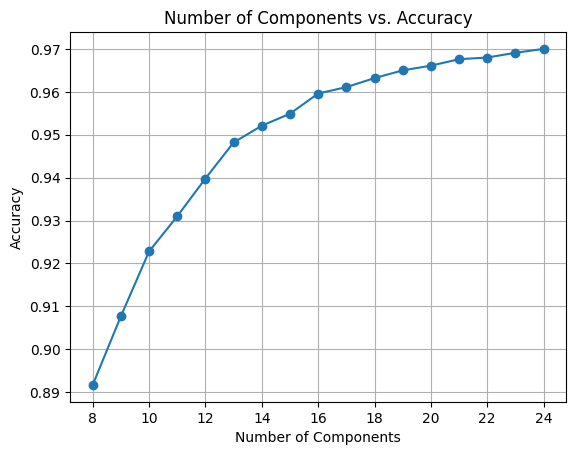

In [5]:
print("Results:")
for target, components in accuracy_targets.items():
    print(f"Minimum components for {target * 100}% accuracy: {components}")

plt.plot(components_list, accuracy_list, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Number of Components vs. Accuracy')
plt.grid(True)
plt.show()

After plotting the results, we see that only a few principal components are needed to achieve high accuracy on the MNIST dataset using k-nearest neighbors. With just 9 components, the model reaches 90% accuracy, while 14 components bring it up to 95%, and 24 components achieve 97%. Accuracy steadily improves as more components are added, but the gains begin to level off around 20 components, indicating that adding further components has diminishing returns. This suggests that most of the essential information for classification is concentrated in the first few components, allowing us to significantly reduce the dimensionality without losing much accuracy. This experiment highlights how PCA can efficiently capture the most relevant patterns in the data, simplifying the model while preserving its effectiveness.